<a href="https://colab.research.google.com/github/bilychka-v/mss/blob/main/lab3/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                 Start program

--------------------------------------------------------------- 
                   Approximations info: 

Iteration    m1         c2         m3         Quality Score
---------------------------------------------------------------
0            10.0000    0.1000     12.0000    72.822930
1            12.2903    0.2233     14.8269    15.239681
2            12.8256    0.2996     17.0440    0.802758
3            12.0874    0.3027     17.9316    0.002298
4            12.0001    0.3000     18.0001    0.000000
---------------------------------------------------------------
---------------------------------------------------------------
Identified Parameters:

      m1: 11.999997
      c2: 0.300000
      m3: 17.999998
      Iterations: 5
      Quality Score: 0.000000
---------------------------------------------------------------



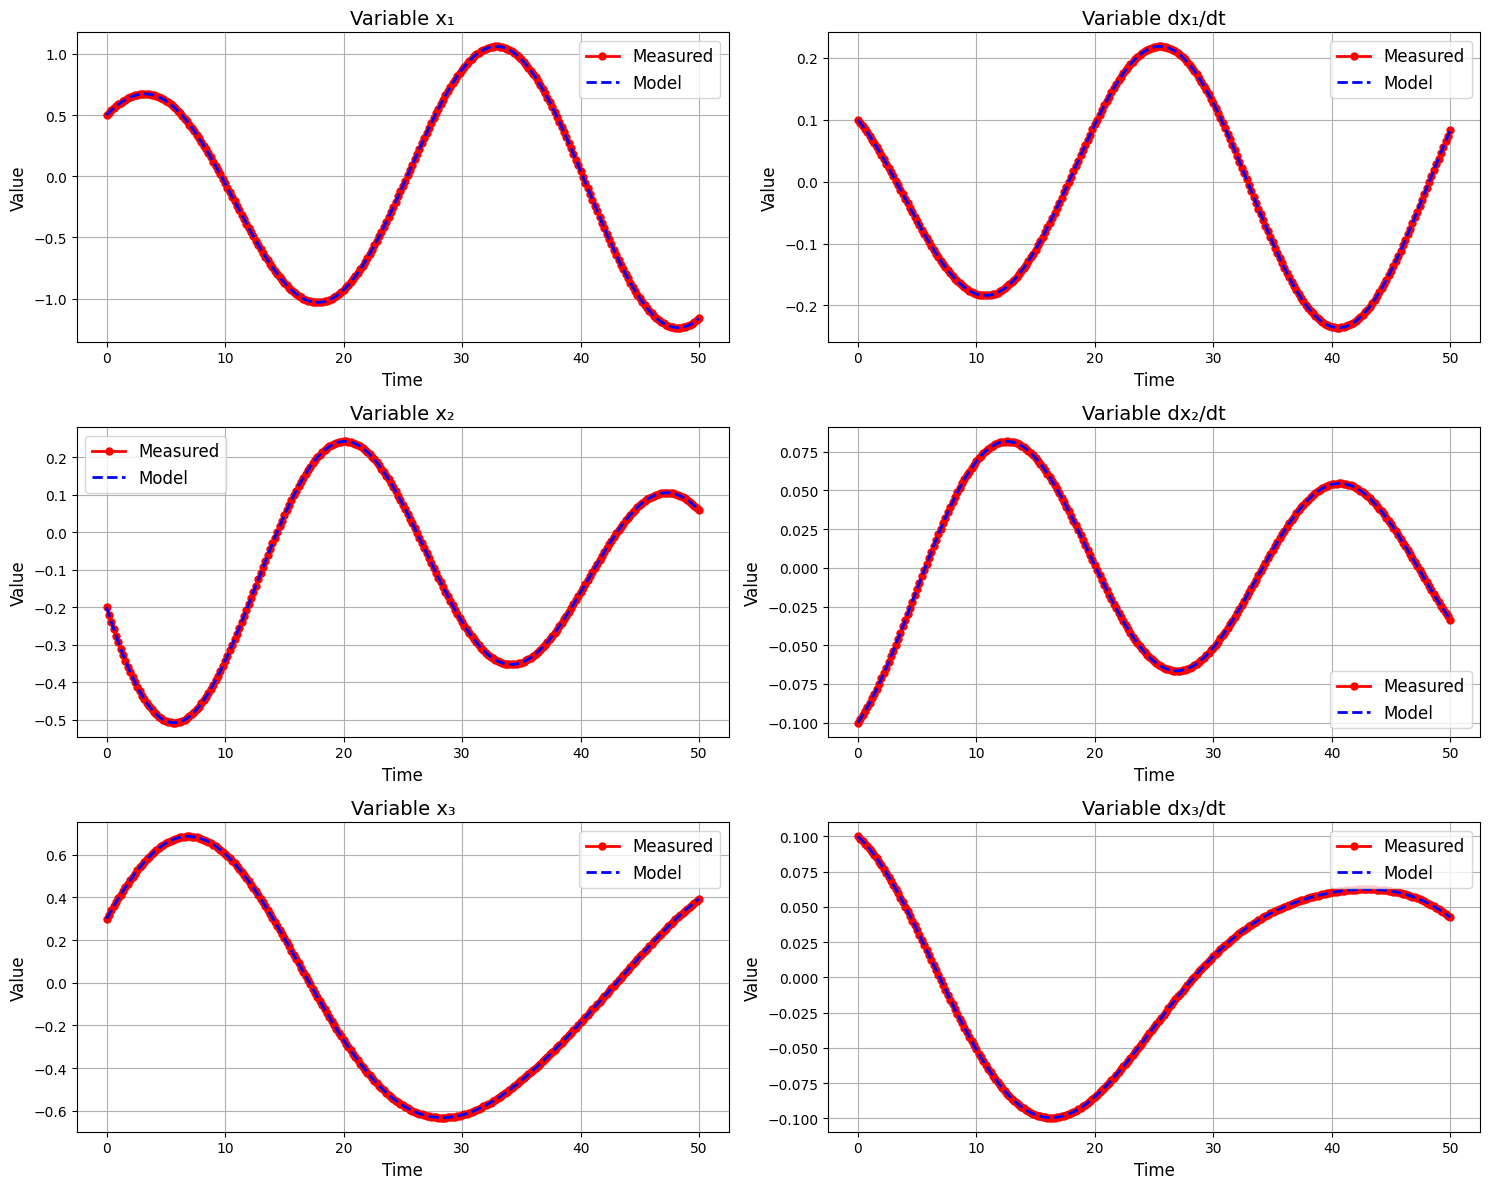

                 End program



In [38]:
import numpy as np
import matplotlib.pyplot as plt

BORDER = '-' * 63  # Рамка для виводу
MIDDLE_SPACE = ' '* 17
DISTANS = ' '*6

# Ініціалізація матриці параметрів
def setup_matrix(params):


    c1 = params['c1']
    c2 = params['c2']
    c3 = params['c3']
    c4 = params['c4']

    m1 = params['m1']
    m2 = params['m2']
    m3 = params['m3']

    matrix = [
        [0, 1, 0, 0, 0, 0],
        [-(c2 + c1) / m1, 0, c2 / m1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [c2 / m2, 0, -(c2 + c3) / m2, 0, c3 / m2, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, c3 / m3, 0, -(c4 + c3) / m3, 0]
    ]

    return np.array(matrix)

# Обчислення чисельних похідних
def compute_derivatives(y_function, param_keys, params, delta=1e-5):

    n = len(y_function(params))
    m = len(param_keys)

    derivative_matrix = np.zeros((n, m))

    for j in range(m):

        original_value = params[param_keys[j]]
        params[param_keys[j]] = original_value + delta
        y_plus = y_function(params)
        params[param_keys[j]] = original_value - delta
        y_minus = y_function(params)
        params[param_keys[j]] = original_value

        derivative_matrix[:, j] = (y_plus - y_minus) / (2 * delta)

    return derivative_matrix


# Оновлення матриці стану за методом Рунге-Кутта
def runge_kutta_step(a_matrix, b_matrix, u_matrix, step_size):

    b_arr = np.array(b_matrix)

    k1 = step_size * (np.dot(a_matrix, u_matrix) + b_arr)

    k2 = step_size * (np.dot(a_matrix, u_matrix + k1 / 2) + b_arr)

    k3 = step_size * (np.dot(a_matrix, u_matrix + k2 / 2) + b_arr)

    k4 = step_size * (np.dot(a_matrix, u_matrix + k3) + b_arr)

    return u_matrix + (k1 + 2 * k2 + 2 * k3 + k4) / 6


# Обчислення нового стану y
def update_state_y(a_matrix, y_current, step_size):

    k1 = step_size * np.dot(a_matrix, y_current)

    k2 = step_size * np.dot(a_matrix, y_current + k1 / 2)

    k3 = step_size * np.dot(a_matrix, y_current + k2 / 2)

    k4 = step_size * np.dot(a_matrix, y_current + k3)

    return y_current + (k1 + 2 * k2 + 2 * k3 + k4) / 6


# Отримання рішення моделі
def solve_model(params, initial_state, time_points, step_size=0.2):

    solution = [initial_state]
    y_current = initial_state

    a_matrix = setup_matrix(params)

    for _ in range(len(time_points) - 1):

        y_current = update_state_y(a_matrix, y_current, step_size)
        solution.append(y_current)

    return np.array(solution)


# Функція для виконання апроксимації
def parameter_approximation(data_matrix, params, target_params, init_values, tolerance, step_size=0.2):

    iteration = 0
    param_vector = np.array([init_values[target_params[0]], init_values[target_params[1]], init_values[target_params[2]]])


    full_params = {**params, **init_values}
    a_matrix = setup_matrix(full_params)


    def model_output(b_values):

        full_params.update(b_values)
        a_matrix = setup_matrix(full_params)

        return a_matrix @ y_approx

    print(f"{BORDER} \n {MIDDLE_SPACE} Approximations info: \n")
    print(f"{'Iteration':<12} {' '.join(f'{p:<10}' for p in target_params)} {'Quality Score'}")
    print(BORDER)  # Рамка для виводу


    while True:

        u_matrix = np.zeros((6, 3))
        quality_score = 0

        inverse_integral = np.zeros((3, 3))
        multiplied_integral = np.zeros((1, 3))
        y_approx = data_matrix[0]


        full_params.update(init_values)
        full_matrix = setup_matrix(full_params)


        for i in range(len(data_matrix)):

            deriv_matrix = compute_derivatives(model_output, target_params, init_values)
            inverse_integral += u_matrix.T @ u_matrix

            multiplied_integral += u_matrix.T @ (data_matrix[i] - y_approx)
            quality_score += (data_matrix[i] - y_approx).T @ (data_matrix[i] - y_approx)

            u_matrix = runge_kutta_step(full_matrix, deriv_matrix, u_matrix, step_size)
            y_approx = update_state_y(full_matrix, y_approx, step_size)


        inverse_integral *= step_size
        multiplied_integral *= step_size

        quality_score *= step_size
        print(f"{iteration:<12} {' '.join(f'{val:<10.4f}' for val in param_vector)} {quality_score:.6f}")

        delta_params = np.linalg.inv(inverse_integral) @ multiplied_integral.flatten()
        param_vector += delta_params
        init_values = {target_params[i]: param_vector[i] for i in range(3)}

        if quality_score < tolerance:
            # print("\n" + "-" * 50)
            # print("Results Summary")
            # print('-' * 50)
            # print("Identified Parameters:")
            # for param, value in init_values.items():
            #     print(f"{param}: {value:.6f}")
            # print(f"Quality Score: {quality_score:.6f}")
            # print(f"Total Iterations: {iteration + 1}")
            print(BORDER)  # Рамка для виводу
            return init_values, iteration + 1, quality_score

        iteration += 1


# Відображення графіку
def display_graph(measured_data, model_solution, time_points):

    variables = ['x₁', 'dx₁/dt', 'x₂', 'dx₂/dt', 'x₃', 'dx₃/dt']
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i, (ax, var) in enumerate(zip(axes, variables)):

        ax.plot(time_points, measured_data[:, i], 'ro-', label='Measured', markersize=5, linewidth=2)
        ax.plot(time_points, model_solution[:, i], 'b--', label='Model', linewidth=2)
        ax.set_title(f'Variable {var}', fontsize=14)
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel('Value', fontsize=12)
        ax.grid(True)
        ax.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

# Читання даних з файлу
def load_data(file_name):

    with open(file_name, 'r') as file:

        lines = file.readlines()
        data_matrix = []

        for line in lines:
            values = line.strip().split()
            row = [float(value) for value in values]
            data_matrix.append(row)

    return np.array(data_matrix).T

def get_data():
    data_matrix = load_data('y2.txt')
    time_points = np.arange(0, 0.2 * len(data_matrix), 0.2)

    # Початкові параметри
    initial_params = {'c1': 0.14, 'c3': 0.2, 'c4': 0.12, 'm2': 28}
    adjustable_params = {'m1': 10, 'c2': 0.1, 'm3': 12}

    target_params = ['m1', 'c2', 'm3']

    return data_matrix,initial_params, target_params, adjustable_params, time_points

def view_results(results, num_iterations, quality):

    print(BORDER)
    print("Identified Parameters:\n")

    for key, value in results.items():
        print(f"{DISTANS}{key}: {value:.6f}")

    print(f"{DISTANS}Iterations: {num_iterations}")
    print(f"{DISTANS}Quality Score: {quality:.6f}")
    print(BORDER + '\n')

# Основна функція для запуску процесу
def main():

    print(f"{MIDDLE_SPACE}Start program\n")

    data_matrix,initial_params, target_params, adjustable_params,time_points = get_data()

    # Виконання апроксимації
    results, num_iterations, quality = parameter_approximation(
        data_matrix, initial_params, target_params, adjustable_params, 1e-6
    )

    # Отримання моделі з визначеними параметрами
    final_params = {**initial_params, **results}
    model_solution = solve_model(final_params, data_matrix[0], time_points)

    view_results(results, num_iterations, quality)
    display_graph(data_matrix, model_solution, time_points)

    print(f"{MIDDLE_SPACE}End program\n")

main()
